In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from PIL import Image
import cv2

import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm import tqdm, trange

data_path = 'ET_dataset/'

### Визуализация размеченного изображения:

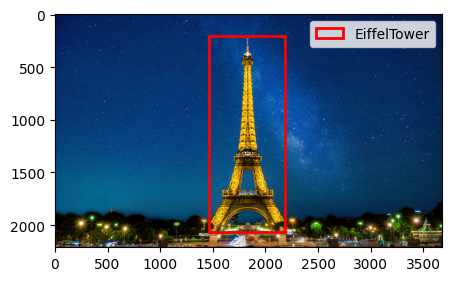

In [3]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 5), squeeze=False)
i = Image.open(data_path + 'img59.jpg')
ax[0][0].imshow(i)

content = pd.read_csv(data_path + 'img59.csv')
markup, label = content['region_shape_attributes'].item(), content['region_attributes'].item()
markup, label = json.loads(markup), json.loads(label)

rect = patches.Rectangle((markup['x'], markup['y']),
                        markup['width'], markup['height'],
                        linewidth = 2,
                        edgecolor = 'r',
                        facecolor = 'none',
                        label=label['bndbox']
                        )

# Draw the bounding box on top of the image
ax[0][0].add_patch(rect)
plt.legend()
plt.show()

### Класс AttractionsDataset:

In [4]:
class AttractionsDataset(Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        # print(self.imgs)
        # classes: 0 index is reserved for background
        self.classes = [_, 'EiffelTower']
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        # print(f'Selected: {img_name}')
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.csv'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        content = pd.read_csv(annot_file_path)
        
        boxes = []
        labels = []
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]

        # box coordinates for csv files are extracted and corrected for image size given
        for i in range(content.shape[0]):
            markup, label = content.loc[i, 'region_shape_attributes'], content.loc[i, 'region_attributes']
            markup, label = json.loads(markup), json.loads(label)
            
            labels.append(self.classes.index(label['bndbox']))
            
            xmin, xmax = int(markup['x']), int(markup['x']) + int(markup['width'])
            ymin, ymax = int(markup['y']), int(markup['y']) + int(markup['height'])
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        

        # convert boxes into a torch.Tensor
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms:

            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)

            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])



        return img_res, target
    
    
    def __len__(self):
        return len(self.imgs)

### Аугментация данных:

In [5]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                            # A.VerticalFlip(p=0.5),
                            A.Rotate(limit=45, p=0.5),
                            A.RandomBrightnessContrast(p=0.3),
            
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

### Подготовка данных:

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

# use our dataset and defined transformations

data_path = 'ET_dataset/'
train_dataset = AttractionsDataset(data_path, 480, 480, transforms = get_transform(train=True))
val_dataset = AttractionsDataset(data_path, 480, 480, transforms = get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()

test_split = 0.2
tsize = int(len(train_dataset)*test_split)
train_dataset = torch.utils.data.Subset(train_dataset, indices[:-tsize])
val_dataset = torch.utils.data.Subset(val_dataset, indices[-tsize:])


# define training and validation data loaders
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn)

### Загрузка модели и создание оптимизатора:

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Current device: {device}")

num_classes = 2


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

Current device: cuda


### Цикл обучения:

In [8]:
def fit(model, loaders, optimizer, lr_scheduler=None, epochs = 10, plot = True, device = 'cpu'):
    model_losses = {"train": [], "valid": []}
    
    for epoch in trange(epochs):
        print(f"Epoch #{epoch}")
        for loader_type, dataloader in loaders.items():
            epoch_losses = []
            for images, targets in dataloader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                if loader_type == 'train':
                    # model.train()
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                    epoch_losses.append(losses.item())
                    losses.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                elif loader_type == 'valid':
                    # model.eval()
                    with torch.no_grad():
                        loss_dict = model(images, targets)
                        losses = sum(loss for loss in loss_dict.values())
                        epoch_losses.append(losses.item())
            model_losses[loader_type].append(np.array(epoch_losses).mean())
            print(f"{loader_type} loss: {model_losses[loader_type][-1]}")
        if lr_scheduler is not None:
            lr_scheduler.step()
    if plot:
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(6, 5), squeeze=False)
        ax[0][0].set_title('Loss')
        ax[0][0].plot(model_losses['train'], label='Train losses')
        ax[0][0].plot(model_losses['valid'], label='Valid losses')
        ax[0][0].legend()
        plt.show();

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Epoch #0
train loss: 0.20590811277981158


 14%|████████████                                                                        | 1/7 [00:53<05:19, 53.30s/it]

valid loss: 0.13272272795438766
Epoch #1
train loss: 0.124871210505565


 29%|████████████████████████                                                            | 2/7 [01:41<04:12, 50.48s/it]

valid loss: 0.11249403761965888
Epoch #2
train loss: 0.10685780244293036


 43%|████████████████████████████████████                                                | 3/7 [02:29<03:16, 49.12s/it]

valid loss: 0.1031145059636661
Epoch #3
train loss: 0.0869554176374718


 57%|████████████████████████████████████████████████                                    | 4/7 [03:15<02:23, 47.87s/it]

valid loss: 0.08765839146716255
Epoch #4
train loss: 0.0766303005317847


 71%|████████████████████████████████████████████████████████████                        | 5/7 [04:01<01:34, 47.36s/it]

valid loss: 0.08511204378945487
Epoch #5
train loss: 0.07340418768149835


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [04:50<00:48, 48.00s/it]

valid loss: 0.08209913543292455
Epoch #6
train loss: 0.0680022875054015


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:38<00:00, 48.33s/it]

valid loss: 0.0815490675824029


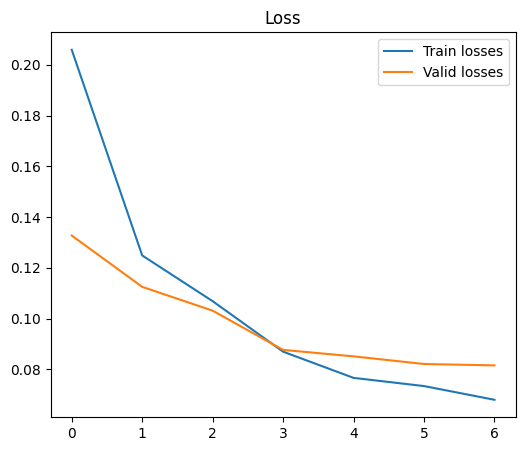

In [9]:
loaders = {"train": train_dataloader, "valid": val_dataloader}
fit(model,
    loaders,
    optimizer,
    lr_scheduler,
    epochs=7,
    plot=True,
    device=device)

In [23]:
# fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20,10), squeeze=False)
# img, target = train_dataset[10]

# ax[0][0].imshow(torch_to_pil(img));

### Тестирование:

In [10]:
def plot_img_bbox(img, target, ax, title):
    ax.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        ax.add_patch(rect)
        ax.set_title(title)

In [11]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchvision.transforms.ToPILImage()(img).convert('RGB')

In [12]:
# Визуализация размеченных изображений непосредственно из датасета
img, target = val_dataset[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    prediction = {k: v.detach().cpu() for k, v in prediction.items()}
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  4
real #boxes:  1


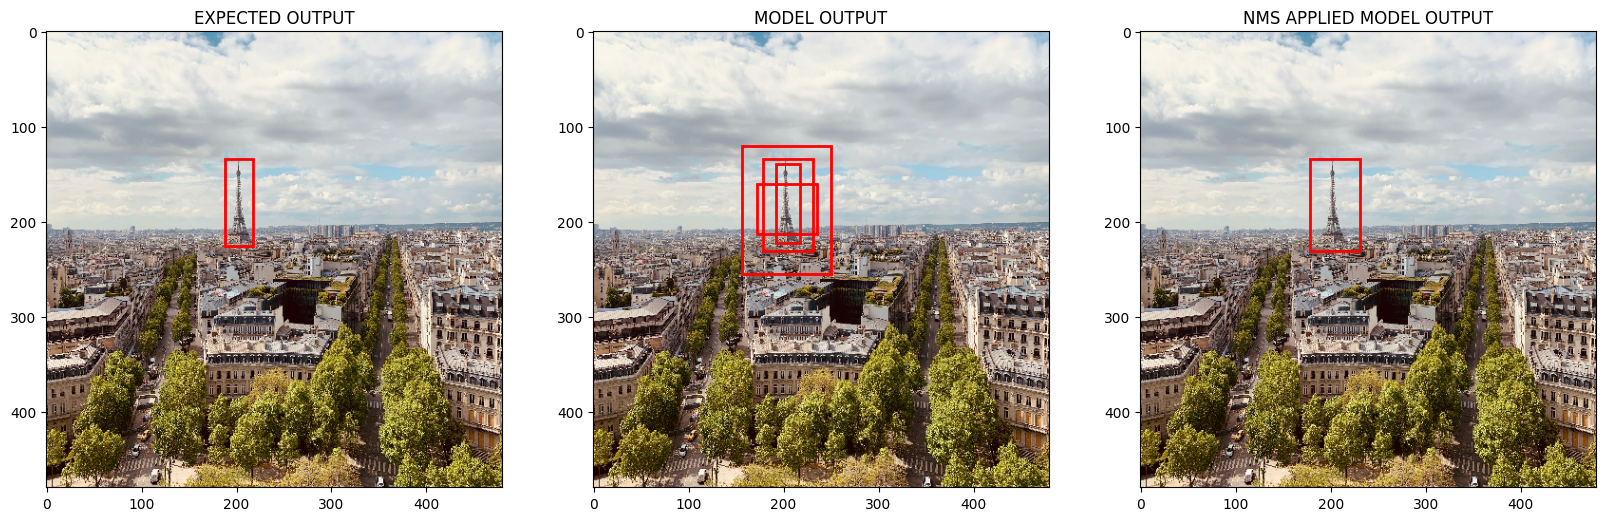

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20,10), squeeze=False)
plot_img_bbox(torch_to_pil(img), target, ax[0][0], title = 'EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction, ax[0][1], title = 'MODEL OUTPUT')

nms_prediction = apply_nms(prediction, iou_thresh=0.2)
plot_img_bbox(torch_to_pil(img), nms_prediction, ax[0][2], title = 'NMS APPLIED MODEL OUTPUT')
plt.show();

In [14]:
def iou(box: torch.Tensor, boxes: torch.Tensor):
    """Calculates a boundary box and multiple bound boxes.

    Parameters
    ----------
    box: Tensor of shape `(4, )`
                 A border box

    boxes: Tensor of shape `(n, 4)`
                 Multiple border boxes

    Returns
    -------
    iou: Tensor of shape `(n, )`
                 Intend
    """
         # Calculate intersection
    xy_max = torch.min(boxes[:, 2:], box[2:])
    xy_min = torch.max(boxes[:, :2], box[:2])
    inter = torch.clamp(xy_max-xy_min, min=0)
    inter = inter[:, 0]*inter[:, 1]

         # Calculate
    area_boxes = (boxes[:, 2]-boxes[:, 0])*(boxes[:, 3]-boxes[:, 1])
    area_box = (box[2]-box[0])*(box[3]-box[1])

    return inter/(area_box+area_boxes-inter)

In [15]:
model.eval()
val_iou = []
for img, target in tqdm(val_dataset):
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        prediction = {k: v.detach().cpu() for k, v in prediction.items()}
    # print('predicted #boxes: ', len(prediction['labels']))
    # print('real #boxes: ', len(target['labels']))
    y_true = target['boxes'].detach().cpu().reshape(-1,)
    y_pred = prediction['boxes'].detach().cpu()
    val_iou.append(torch.max(iou(y_true, y_pred)).item())

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23it/s]


In [16]:
print(f"Validation IOU: {np.array(val_iou).mean():.2f}")

Validation IOU: 0.84
